<div align="center">
  
# Analysis of Optimal Car Models

### CP321 Data Visualization

##### Torin Borton-McCallum - 190824620
##### Jasleen Pabla - 190404270
##### Shakib Ahmed - 210676190

</div>


## Introduction

---

The dataset we used can be retrieved by [clicking here.](https://data.ontario.ca/dataset/vehicle-population-data)

This data set contains the following information:
 
- Vehicle class
- Make/Manufacturer
- Model
- Model Year
- Fit Active Count
- Fit Inactive Count
- Unfit Count
- Wrecked Count
- Registered Out of Province Count

The data collected was from January 1, 2022 to December 31, 2022 in Ontario.

## Motivation

---

In today's data-driven world, understanding what cars people are driving in Ontario is key. This report dives into the data to uncover the highest percentage of cars sold, the durability of vehicles based on model, and what it all means for Ontario's roads and communities.

Understanding Ontarians' car preferences is crucial for guiding smarter decisions by carmakers and policymakers alike. Assessing the fitness of these vehicles provides insights into safety and environmental considerations. By identifying differences across various demographics and regions, we can strive towards ensuring equitable access to safe and eco-friendly transportation options for all. Ultimately, this report endeavors to untangle Ontario's automotive landscape, fostering safer and cleaner roads for everyone.


#### Imports

---

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.io as pio
pio.renderers.default = 'iframe' # Renders the plotly scatterplot and treemap offline

#### Load Data

---



In [19]:
cars_file = "MakeAndModel.TXT"
desc_file = "Descriptors.TXT"

cars = pd.read_csv(cars_file, delimiter='\t') #read file
cars = cars[cars['VEHICLE_CLASS'] == 'PASSENGER'] # take only passenger cars (no motorcycles, mopeds, etc)
cars = cars[cars['MAKE'] != '****'] # drop cars with unknown manufacturer
cars = cars.drop(columns=['VEHICLE_CLASS','OUT-OF-PROV', 'SOLD', 'SUSPENDED', 'TEMPORARY']) # remove unused columns

descriptors = pd.read_csv(desc_file, delimiter='\t') #read file
descriptors = descriptors[descriptors['VEHICLE_CLASS'] == 'PASSENGER'] # take only passenger cars (no motorcycles, mopeds, etc)
descriptors = descriptors.drop(columns=['VEHICLE_CLASS','OUT-OF-PROV', 'SOLD', 'SUSPENDED', 'TEMPORARY']) # remove unused columns

descriptors = descriptors[(descriptors['DESCRIPTOR'] != 'YEAR') & (descriptors['DESCRIPTOR'] != 'MOTIVE POWER')] #unused rows
descriptors = descriptors[(descriptors['VALUE'] != 'OTHER')& (descriptors['VALUE'] != 'MH')]

#### Optimal Manufacturing Year Range

---

First we will explore the relationship between a car's age and its condition. By analyzing the percentage of active, unfit, and wrecked cars based on their manufacturing years. By doing this we aim to understand how car age impacts their status on the road and what the optimal range of manufacturing years would be reccomended when purchasing a new vehicle in terms of safety and durability.

In [20]:
# Group the filtered data by manufacturing year and calculate the percentages for each year
active_fit_percentage_by_year = (cars.groupby('MODEL-YEAR')['FIT-ACTIVE'].sum() /  # cars being driven
                                 cars.groupby('MODEL-YEAR')['TOTAL'].sum()) * 100
unfit_percentage_by_year = (cars.groupby('MODEL-YEAR')['UNFIT'].sum() / #cars not fit to drive but not wrecked
                            cars.groupby('MODEL-YEAR')['TOTAL'].sum()) * 100
wreck_percentage_by_year = (cars.groupby('MODEL-YEAR')['WRECKED'].sum() /
                            cars.groupby('MODEL-YEAR')['TOTAL'].sum()) * 100

# Create a DataFrame from the calculated percentages used to graph scatterplot
data = {'Manufacturing Year': active_fit_percentage_by_year.index,
        'Active Cars': active_fit_percentage_by_year.values,
        'Unfit Cars': unfit_percentage_by_year.values,
        'Wrecked Cars': wreck_percentage_by_year.values}
df = pd.DataFrame(data)

# Create the scatter plot using Plotly Express
fig = px.scatter(df, x='Manufacturing Year',
                 y=['Active Cars', 'Unfit Cars', 'Wrecked Cars'], #add df items to y axis
                 title='Percentage of Active Fit, Unfit, and Wrecked Cars vs. Manufacturing Year',
                 labels={'Manufacturing Year': 'Year', 'value': 'Percent', 'variable': 'Type'})

# Show the plot
fig.show()

Concluding our analysis, we observed distinct trends in the scatter plot representing active, unfit, and wrecked cars across different manufacturing years. Notably, fit cars and wrecked cars displayed relatively opposing trajectories, indicating a clear relation between well-maintained vehicles and wrecked cars. However, what stood out was the behavior of unfit cars, which followed an intermediary pattern. Particularly, we noticed that older cars, dating approximately from 1900 to 1960, fell into the unfit category but were not necessarily wrecked, aligning closely with the trends seen in fit cars. 

However, as we approached more recent manufacturing years, unfit cars began to mirror the trajectory of wrecked cars. This shift suggests a critical turning point in vehicle longevity and maintenance practices and also is likely  reflective of the interest consumers have in classic cars,
 which would explain why data is more chaotic for fit and unfit cars in this range. Furthermore, we identified an optimal range, notably from 2010 onwards, where the prevalence of unfit and wrecked cars was low, while the proportion of fit cars was high. This period highlights a potential sweet spot in vehicle reliability and longevity, indicative of advancements in automotive engineering and maintenance practices in recent years. We will be using this manufacturing year in the next visualization.
<br>
<br>

#### What are the most durable manufacturers to purchase cars from?
---

It's crucial that customers take reliability into account, purchasing from a reliable manufacturer ensures that you get to drive your vehicle hassle-free. Maintenance costs can add up to a lot over time when you have an unreliable car!

From the first question, we concluded that we want to analyze cars that are 2010 or newer. To narrow down the best manufacturers under this year range, we can look at the proportions of active cars to total cars across all manufacturers. If a certain manufacturers has a low percentage of active cars to total cars, this means the majority of their cars are not on the road today which can be a major sign of unreliability. 

After finding the manufacturers with the best proportions, we then sort them by the highest total count of active cars to conclude which manufacturers are the most reliable. We selected manufacturers with a sample size of at least 50,000 cars, as this is would indicate an experienced manufacturers with a reliable amount of cars to judge from.

In [21]:
new_cars = cars[cars['MODEL-YEAR'] >= 2010] #take only cars made 2010 or newer

# Group by 'MAKE' and sum 'FIT-ACTIVE' and 'TOTAL' values
active_cars = new_cars.groupby('MAKE')[['FIT-ACTIVE', 'TOTAL']].sum()

# Sort the DataFrame by the summed 'FIT-ACTIVE' percentages and add new column to df
active_cars['FIT-PERCENTAGE'] = (active_cars['FIT-ACTIVE'] / active_cars['TOTAL']) * 100

#take only brands with over 50000 cars to remove small companies
active_cars = active_cars[active_cars['TOTAL'] > 50000]

active_cars = active_cars.sort_values(by='FIT-PERCENTAGE', ascending=False)

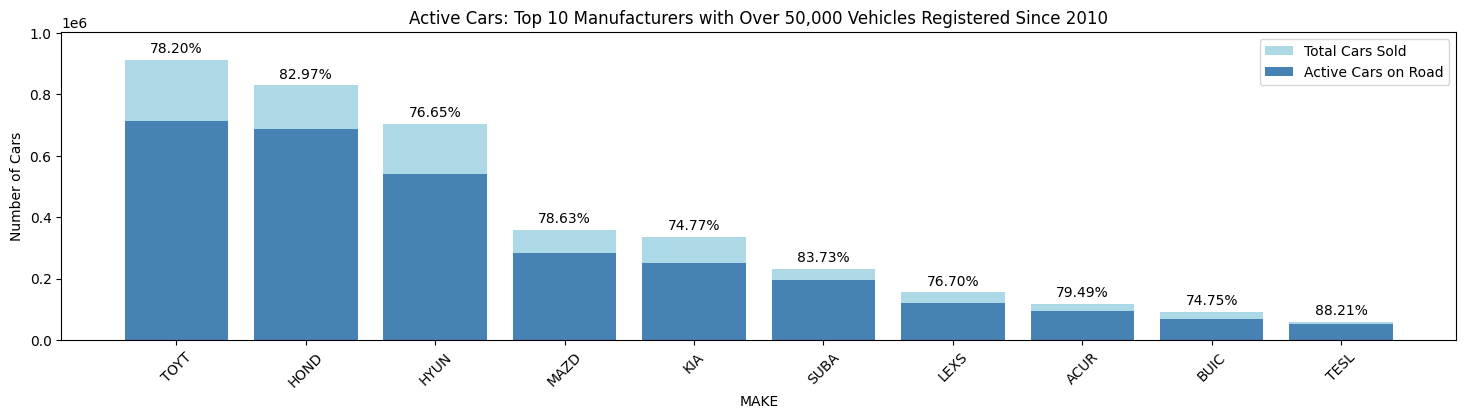

In [22]:
# Select the top 10 makes with the highest percentage of active cars from total cars
top10 = active_cars.nlargest(10, 'FIT-PERCENTAGE')

# Sort the car makes by most active cars on the road
top10 = top10.nlargest(10, 'FIT-ACTIVE')

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(18, 4))
bars = ax.bar(top10.index, top10['TOTAL'], color='lightblue', label='Total Cars Sold')
ax.bar(top10.index, top10['FIT-ACTIVE'], color='steelblue', label='Active Cars on Road')
ax.set_xlabel('MAKE')
ax.set_ylabel('Number of Cars')
ax.set_title('Active Cars: Top 10 Manufacturers with Over 50,000 Vehicles Registered Since 2010')
ax.tick_params(axis='x', rotation=45)

# Annotate each bar with the percentage value
for bar, percentage in zip(bars, top10['FIT-PERCENTAGE']):
    height = bar.get_height()
    ax.annotate(f'{percentage:.2f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

# Set y-axis limits with extra space above the largest bar
largest_bar_height = max(top10['TOTAL'])
ax.set_ylim(top=largest_bar_height * 1.1)  # Increase by 10% above the largest bar height to avoid overlap

# Move legend to the top right corner
ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))

# Display the plot
plt.show()

We can see in the above stacked bar chart that <b>Toyota and Honda</b> are the most reliable car manufacturers to purchase from. 78.20% of all of Toyota's cars are active on the road, while Honda's metric is 82.97%. Toyota, however, has a higher total amount of active cars on the road today, and thus we can consider either of these two manufacturers going forward.
<br>
<br>

#### What are the most popular and reliable car models?
---

Identifying the most active car models reveals consumer preferences and brand loyalty trends. It allows manufacturers to understand which models have sustained popularity and market demand over time. Additionally, it can highlight successful design, performance, and marketing strategies employed by manufacturers. Alongside the manufacturers, this is also an important statistic for consumers to understand when making purchases. Brand loyalty is usually kickstarted from a quality product and good customer service, and especially in the car industry, there are many models that people generally consider as reliable and good purchases. 

Isolating the top 10 car manufacturers we found in the previous question allows us to pinpoint reliable car models going forward. After selecting those manufacturers, we can filter the top 5 cars in each of those manufacturers and sort them by the ones that have the most fit and active counts on the road. For the sake of trying to pinpoint specific car models, for this visualization we have dropped any data linked to a car manufacturer that did not also indicate what model the data was for.

In [23]:
# adjust cars df to only account for the top 10 car brands we found above
makes_list = top10.index.tolist()
top_cars = cars[cars['MAKE'].isin(makes_list)] #filter only cars in top list
top_cars = top_cars[top_cars['MODEL'] != '***']#drop unknown data

In [24]:
# Filter top_cars to include only 'FIT-Active' cars
fit_active_cars = top_cars[top_cars['FIT-ACTIVE'] > 0]

# Group the data by both 'MAKE' and 'MODEL' and sum the 'FIT-ACTIVE' values
grouped_cars = fit_active_cars.groupby(['MAKE', 'MODEL'])['FIT-ACTIVE'].sum().reset_index()

# Sort the data within each 'MAKE' group by 'FIT-ACTIVE' values in descending order
grouped_cars_sorted = grouped_cars.groupby('MAKE').apply(lambda x: x.nlargest(5, 'FIT-ACTIVE')).reset_index(drop=True)

# Create the treemap for total 'FIT-ACTIVE' Civics for each make
fig = px.treemap(grouped_cars_sorted,
                 path=['MAKE', 'MODEL'],
                 values='FIT-ACTIVE',
                 title='Top 5 Most Popular Active Car Models Across the Top 10 Most Reliable Manufacturers')
fig.show()

Looking at the above treemap, we can make the following observations about our 10 most reliable manufacturers that were previously selected. Referring  

<b>Honda's</b> most popular cars are the <b>Odyssey, CRV, Civic LX, Civic EX, and Pilot.</b><br>
<b>Toyota's</b> most popular cars are the <b>RAV4, Corolla MTL, Sienna, Highlander, and Corolla UCS.</b><br>
<b>Hyundai's</b> most popular cars are the <b>Tucson, Elantra, Santa Fe, Sante Fe Sport, and Elantra EV.</b><br>
<b>Mazda's</b> most popular cars are the <b>CX5, Mazda3, Mazda3i, CX9, and Mazda3S.</b><br>
<b>Kia's</b> most popular cars are the <b>Sorento, Soul, Sportage, Sportage FNG, and Sorento SEO. </b><br>
<b>Subaru's</b> most popular cars are the <b>Forester, Crosstrek, Outback, Baja, and Impreza.</b><br>
<b>Acura's</b> most popular cars are the <b>RDX, MDX, TLX, TSX, and ATL.</b><br>
<b>Lexus's</b> most popular cars are the <b>RX500, ES, RX, NX, and NX300.</b><br>
<b>Buick's</b> most popular cars are the <b>Encore, Enclave, Verano, Encore GX, and Envision.</b><br>
<b>Tesla's</b> most popular cars are the <b>Model 3, Model Y, Model 3 MSS, Model X.</b><br>
<br>
<br>

#### Optimal Car Features

---

In this section, we aim to discover which car features are most conducive to active vehicles. We'll explore how factors like cylinder count and body type influence the percentage of active cars. By using a heatmap, we'll highlight which features tend to correlate with higher activity rates. This investigation will help us identify the optimal characteristics for cars, such as the ideal cylinder count and body type, and based on the above results determine which cars fit this criteria.

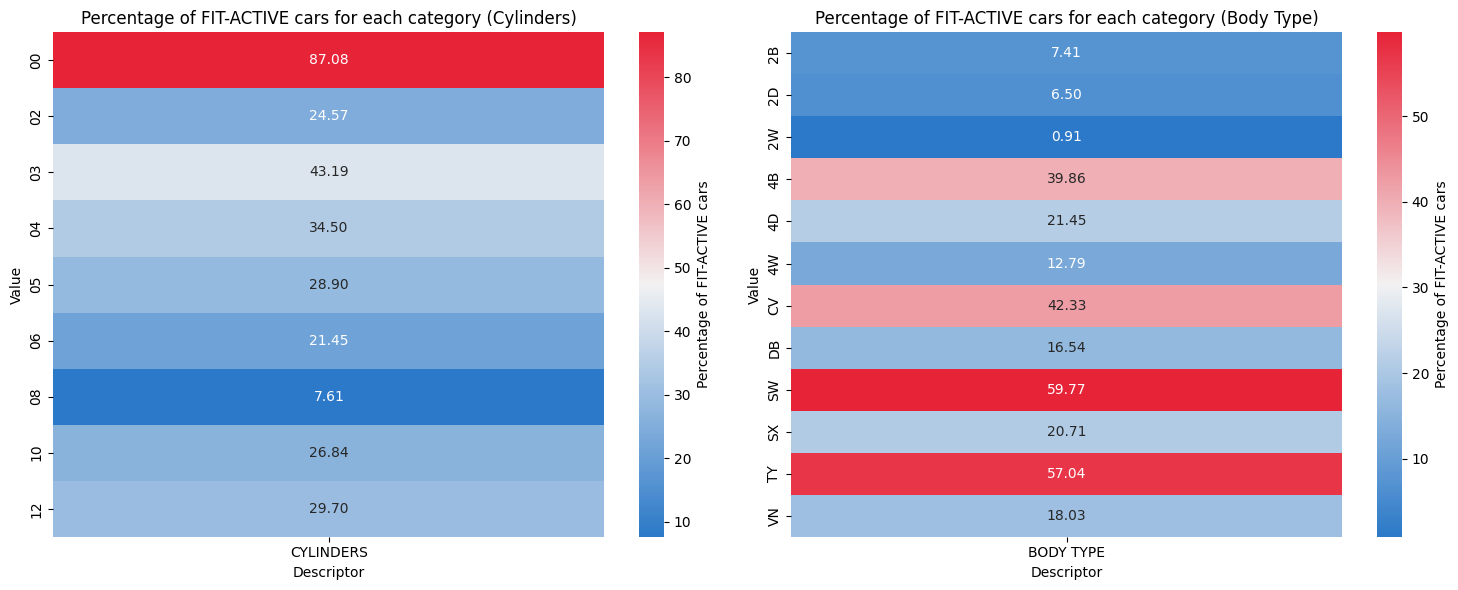

In [25]:
# Filter descriptors for cylinders
cylinders_descriptors = descriptors[descriptors['DESCRIPTOR'] == 'CYLINDERS'].copy()

# Calculate the percentage of FIT-ACTIVE cars for each category in cylinders
percentage_fit_active_cylinders = (cylinders_descriptors['FIT-ACTIVE'] / cylinders_descriptors['TOTAL']) * 100

# Add the calculated percentages as a new column using .loc
cylinders_descriptors.loc[:, 'FIT-ACTIVE_PERCENTAGE'] = percentage_fit_active_cylinders

# Pivot the DataFrame for plotting
heatmap_data_cylinders = cylinders_descriptors.pivot(index='VALUE', columns='DESCRIPTOR', values='FIT-ACTIVE_PERCENTAGE')

# Filter descriptors for body type
body_type_descriptors = descriptors[descriptors['DESCRIPTOR'] == 'BODY TYPE'].copy()

# Calculate the percentage of FIT-ACTIVE cars for each category in body type
percentage_fit_active_body_type = (body_type_descriptors['FIT-ACTIVE'] / body_type_descriptors['TOTAL']) * 100

# Add the calculated percentages as a new column using .loc
body_type_descriptors.loc[:, 'FIT-ACTIVE_PERCENTAGE'] = percentage_fit_active_body_type

# Pivot the DataFrame for plotting
heatmap_data_body_type = body_type_descriptors.pivot(index='VALUE', columns='DESCRIPTOR', values='FIT-ACTIVE_PERCENTAGE')

# Define custom color map
custom_cmap = sns.diverging_palette(250, 10, s=90, l=50, as_cmap=True)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the heatmap for cylinders
sns.heatmap(heatmap_data_cylinders, cmap=custom_cmap, annot=True, fmt=".2f", cbar_kws={'label': 'Percentage of FIT-ACTIVE cars'}, ax=axes[0])
axes[0].set_title('Percentage of FIT-ACTIVE cars for each category (Cylinders)')
axes[0].set_xlabel('Descriptor')
axes[0].set_ylabel('Value')

# Plot the heatmap for body type
sns.heatmap(heatmap_data_body_type, cmap=custom_cmap, annot=True, fmt=".2f", cbar_kws={'label': 'Percentage of FIT-ACTIVE cars'}, ax=axes[1])
axes[1].set_title('Percentage of FIT-ACTIVE cars for each category (Body Type)')
axes[1].set_xlabel('Descriptor')
axes[1].set_ylabel('Value')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


The top 5 categories for FIT-ACTIVE users in terms of cylinders present an interesting mix of vehicle types. Electric and hybrid cars with 0 cylinders lead the pack, reflecting a growing preference for eco-friendly options among fitness-conscious individuals. Following closely are cars with 3 cylinders, suggesting a willingness among consumers to prioritize fuel efficiency without sacrificing performance entirely. Traditional 4-cylinder cars remain popular, appealing to a broad audience due to their balance of power and efficiency. Interestingly, luxury vehicles with 12 cylinders also make the list, indicating that some fitness enthusiasts may favor high-performance cars for their style and capabilities. These results highlight the diverse preferences of consumers and the various factors influencing their car choices, including environmental concerns, performance, and lifestyle preferences.

The analysis of FIT-ACTIVE users extends beyond just cylinders to include body types, revealing further insights into consumer preferences. The top 5 categories for FIT-ACTIVE users based on body type offer a diverse range of options. Station Wagons (SW) claim the top spot, suggesting their appeal to individuals with active lifestyles who prioritize space and versatility for outdoor activities. Trucks (TY) closely follow, indicating their popularity among those who require ruggedness and heavy duty work capability. Convertibles (CV) hold the third position, likely indicating users with these cars tend to have more interest in maintaining these vehicles. Meanwhile, four-door sedans (4B) and hatchbacks (4D) also showed high percentages, suggesting that practicality and functionality are key factors for FIT-ACTIVE users when selecting a vehicle. These results underscore the importance of considering both vehicle features and lifestyle preferences in understanding consumer behavior in the vehicle market.
<br>
<br>

## Conclusion
---

In conclusion, these questions collectively offer a comprehensive view of the Ontario vehicle population, encompassing longevity, consumer preferences, and trends in vehicle fitness over time. The insights derived from addressing these questions can inform decisions related to manufacturing, marketing, safety regulations, and infrastructure development within the automotive industry.

Our analysis identifies optimal car choices based on body type, cylinder count, and manufacturing year range.

Optimal Manufacturing Year Range:
Cars manufactured from 2010 onwards offer enhanced reliability and longevity, reflecting advancements in automotive engineering and maintenance practices.

Most Durable Manufacturers:
Honda and Subaru emerge as reliable choices, offering models with high percentages of active cars on the road.

Popular Car MakesOdyssey and Toyota anRAV4u's Outback stand out as popular choices, providing versatility and reliability for a range of preferences.

Optimal Car Recommendations:
For FIT-ACTIVE users seeking environmentally-friendly options, the Honda Fit or Subaru Crosstrek Hybrid are recommended. Both offer agility and fuel efficiency, suitable for urban commuting.

For individuals with active lifestyles requiring ample cargo space, the Honda CR-V or Subaru Outback are ideal choices. These SUVs provide versatility and rugged capability for outdoor adventures.

Conclusion:
Optimal car selection involves considering body type, cylinder count, and manufacturing year range. Honda and Subaru offer reliable choices that cater to FIT-ACTIVE users' preferences for performance, versatility, and efficiency.ty, and efficiency.